# Análise do Dataset Movie Lens Small

**D1AED – Análise Estatística para Ciência de Dados**<br />
Especialização em Ciência de Dados - IFSP Campinas

Alunos
- Daniel Vargas Shimamoto
- Diego Machado de Assis

# 0. Informações Gerais

## 0.1 Conhecendo o dataset

Trata-se do conjunto de dados [Movie Lens Small](https://files.grouplens.org/datasets/movielens/ml-latest-small.zip), contendo classificação de filmes do serviço de recomendação [movielens](http://movielens.org).

### 0.1.1 Informações do [README](data/ml-latest-small/README.txt) do dataset

O dataset contém **100.836 avaliações** e **3.683 *rótulos*** para **9.742 filmes**. Os dados foram criados por **610 usuários** entre 29/03/1996 e 24/09/2018. Cada usuário avaliou pelo menos 20 filmes.

Os arquivos estão em formato *CSV*, com uma única linha de cabeçalho. Colunas que contenham vírgula estão escapadas com aspas duplas. Codificação é UTF-8.

- **User Ids**: São consistentes entre os arquivos `ratigns.csv` e `tags.csv` (mesmo *id* se refere a um mesmo usuário nestes dois arquivos)
- **Movie Ids**: Apenas filmes com ao menos uma avaliação ou *rótulo* estão inclusos no dataset. Ids são consistentes entre os arquivos `ratings.csv`, `tags.csv`, `movies.csv` e `links.csv`

#### `ratings.csv`
> 100.836 avaliações

Cada linha do arquivo representa uma avaliação de um filme por um usuário, no seguinte formato:

    userId,movieId,rating,timestamp

As avaliações estão em uma escala de *5 estrelas*, com incrementos de *0,5 estrelas* (0,5 - 5.0). *Timestamp* é uma valor em [Unix time](https://en.wikipedia.org/wiki/Unix_time).

#### `tags.csv`
> 3.683 *rótulos*

Cada linha do arquivo representa um *rótulo* atribuído a um filme por um usuário, no seguinte formato:

    userId,movieId,tag,timestamp

*Rótulos* são metadados dos filmes, formadas em geral por palavras únicas ou frases curtas. *Timestamp* é uma valor em [Unix time](https://en.wikipedia.org/wiki/Unix_time).

#### `movies.csv`
> 9.742 filmes

Cada linha do arquivo representa um filme, no seguinte formato:

    movieId,title,genres

Os títulos dos filmes podem conter erros e inconsistências. O ano de lançamento está incluso entre parêntesis.

Os gêneros estão em uma lista separadas por pipe (`|`), e são selecionados dos seguintes valores:

* Action
* Adventure
* Animation
* Children's
* Comedy
* Crime
* Documentary
* Drama
* Fantasy
* Film-Noir
* Horror
* Musical
* Mystery
* Romance
* Sci-Fi
* Thriller
* War
* Western
* (no genres listed)

#### `links.csv`
> 9.742 *links*

Cada linha do arquivo representa um filme, contendo *links* para outras fontes de dados de filmes, no seguinte formato:

    movieId,imdbId,tmdbId

*movieId* é um identificador dos filmes usado pelo [movielens](https://movielens.org)<br />
*imdbId* é um identificador dos filmes usado pelo [IMDb](http://www.imdb.com)<br />
*tmdbId* é um identificador dos filmes usado pelo [TMDB](https://www.themoviedb.org)

### 0.1.2 Diagrama dos Dados

A partir da especificação dos dados, podemos traçar um diagrama para melhor visualizar a relação entre as diferentes tabelas. Isto nos ajudará no momento de validar e limpar os dados carregados.

![](https://github.com/dieguim-ifsp-posCD/D1AED/blob/evaluation-01/avaliacoes/20210513-avaliacao01/recursos/20210524-diagrama_dados.png?raw=1)

## 0.2 Importação do Dataset

In [1]:
# Importação das bibliotecas usadas no decorrer do trabalho
import numpy as np
import pandas as pd
from scipy import stats

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter

In [2]:
# Define tconfigurações dos gráficos
sns.set_theme(style='dark', rc={'axes.titlesize': 18, 'axes.labelsize': 14, 'axes.grid.axis': 'y'})

In [3]:
# Importação dos arquivos CSVs
DATAPATH = 'https://raw.githubusercontent.com/dieguim-ifsp-posCD/D1AED/evaluation-01/avaliacoes/20210513-avaliacao01/data/ml-latest-small'

ratings_df = pd.read_csv(f'{DATAPATH}/ratings.csv')
tags_df    = pd.read_csv(f'{DATAPATH}/tags.csv')
movies_df  = pd.read_csv(f'{DATAPATH}/movies.csv')
links_df   = pd.read_csv(f'{DATAPATH}/links.csv')

In [4]:
ratings_df.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [5]:
tags_df.head(3)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992


In [6]:
movies_df.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [7]:
links_df.head(3)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0


## 0.3 Consistência dos dados

Verifica se os dados carregados estão de acordo com a especificação fornecida pela documentação.

Para os *dataset* relevantes fornecidos (**ratings**, **tags** e **movies**), verifica primeiramente se o número de registros, a lista de atributos e os tipos de cada atributo estão corretos segundo a especificação. Em seguida é feita uma verificação dos dados de cada atributo, considerando suas especificidades.

Ao final, é verificada a consistência entre os atributos que relacionam os diferentes *dataset*.

Caso alguma inconsistência seja encontrada em qualquer uma das etapas, um erro é lançado e a execução do notebook é interrompida.

### 0.3.1 Dataset *Ratings*

#### 0.3.1.1 Linhas e Colunas

Verifica o número de registros, nomes e tipos dos atributos, de acordo com o especificado pela documentação

In [8]:
linhas_esperadas = 100836
colunas_esperadas = ['userId', 'movieId', 'rating', 'timestamp']

(num_linhas, num_colunas) = ratings_df.shape
lista_colunas = list(ratings_df.columns)

assert num_linhas == linhas_esperadas, 'Número de linhas não condiz com o esperado'
assert num_colunas == len(colunas_esperadas), 'Número de colunas não condiz com o esperado'
assert lista_colunas == colunas_esperadas, 'Colunas inconsistentes com o esperado'

print(f'Número de linhas `{num_linhas}` e lista de colunas `{lista_colunas}` do DataFrame Ratings estão corretos')

Número de linhas `100836` e lista de colunas `['userId', 'movieId', 'rating', 'timestamp']` do DataFrame Ratings estão corretos


In [9]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Não há valores nulos em nenhum atributo de nenhum registro do DataFrame *ratings*

O tipo de todos os atributos é condizente com o que esperamos:
- **userId** e **movieId** são *inteiros*, como esperado para Ids
- **rating** é *real*, conforme esperado, pois as avaliações estão em um intervalo de 0,5 estrelas
- **timestamp** é *inteiro*, como esperado para um valor de *Unix time*

#### 0.3.1.2 Atributo *userId*

In [10]:
# Verificação da quantidade de usuários únicos
# De acordo com especificação, todos usuários avaliaram pelo menos 20 filmes, logo todos devem estar presentes no DataFrame
usuarios_esperados = 610

num_usuarios = len(ratings_df.userId.unique())

assert num_usuarios == usuarios_esperados, 'Número de usuários não condiz com o esperado'

print(f'Número de usuários `{num_usuarios}` do DataFrame está correto')
print(f'{(num_usuarios/usuarios_esperados * 100):.2f}% dos usuários realizaram avaliação de algum filme')

Número de usuários `610` do DataFrame está correto
100.00% dos usuários realizaram avaliação de algum filme


#### 0.3.1.3 Atributo *movieId*

In [11]:
# Verificação quantidade de filmes avaliados
# A especificação não diz que todos os filmes possuem avaliação (alguns filmes podem possuir apenas rótulos),
# portanto iremos avaliar apenas se o número de ids de filmes é menor do que o total do dataset
filmes_maximo = 9742

num_filmes = len(ratings_df.movieId.unique())

assert num_filmes <= filmes_maximo, 'Número de filmes é maior do que o máximo esperado'

print(f'Número de filmes `{num_filmes}` no DataFrame está dentro do limite máximo esperado')
print(f'{(num_filmes/filmes_maximo * 100):.2f}% dos filmes receberam pelo menos uma avaliação')

Número de filmes `9724` no DataFrame está dentro do limite máximo esperado
99.82% dos filmes receberam pelo menos uma avaliação


#### 0.3.1.4 Atributo *rating*

In [12]:
# Verificação das avaliações
# De acordo com a especificação, as notas estão no intervalo [0.5, 5.0], com saltos de 0.5
avaliacoes_esperadas = np.arange(0.5, 5.1, 0.5) # Colocamos um valor ligeiramente maior que 5.0 como 'stop' para que o '5.0' seja incluido

lista_avaliacoes = ratings_df.rating.sort_values().unique()

assert set(lista_avaliacoes).issubset(set(avaliacoes_esperadas)), 'Lista de avaliações possui valores diferentes do esperado'

print(f'Avaliações `{lista_avaliacoes}` dos registros do DataFrame estão dentro do conjunto esperado')

Avaliações `[0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]` dos registros do DataFrame estão dentro do conjunto esperado


#### 0.3.1.5 Atributo *timestamp*

In [13]:
# Verificação do intervalo de datas
# De acordo com a especificação, as avaliações devem estar entre 29/03/1996 e 24/09/2018
data_minima = pd.to_datetime('1996-03-29 00:00:00')
data_maxima = pd.to_datetime('2018-09-24 23:59:59')

ratings_data_minima = pd.to_datetime(min(ratings_df.timestamp), unit='s', origin='unix')
ratings_data_maxima = pd.to_datetime(max(ratings_df.timestamp), unit='s', origin='unix')

assert ratings_data_minima > data_minima, 'Existe data mais antiga em ratings do que o esperado'
assert ratings_data_maxima < data_maxima, 'Existe data mais recente em ratings do que o esperado'

print(f'Datas de avaliação entre {ratings_data_minima} e {ratings_data_maxima} estão dentro do esperado')

Datas de avaliação entre 1996-03-29 18:36:55 e 2018-09-24 14:27:30 estão dentro do esperado


#### 0.3.1.6 Duplicações

In [14]:
# Verificando se um mesmo usuário realizou mais de uma avaliação de um determinado filme
avaliacoes_duplicadas = ratings_df[ratings_df.duplicated(subset=['userId', 'movieId'])]

assert len(avaliacoes_duplicadas) == 0, 'Existem avaliações duplicadas'

print('Nenhuma avaliação duplicada (mesmo usuário avaliando um mesmo filme mais de uma vez) no dataset')

Nenhuma avaliação duplicada (mesmo usuário avaliando um mesmo filme mais de uma vez) no dataset


### 0.3.2 Dataset *Tags*

#### 0.3.2.1 Linhas e Colunas

Verifica o número de registros, nomes e tipos dos atributos, de acordo com o especificado pela documentação

In [15]:
# Verificação do número de linhas e lista de colunas, de acordo com a especificação do dataset
linhas_esperadas = 3683
colunas_esperadas = ['userId', 'movieId', 'tag', 'timestamp']

(num_linhas, num_colunas) = tags_df.shape
lista_colunas = list(tags_df.columns)

assert num_linhas == linhas_esperadas, 'Número de linhas não condiz com o esperado'
assert num_colunas == len(colunas_esperadas), 'Número de colunas não condiz com o esperado'
assert lista_colunas == colunas_esperadas, 'Colunas inconsistentes com o esperado'

print(f'Número de linhas `{num_linhas}` e lista de colunas `{lista_colunas}` do DataFrame Tags estão corretos')

Número de linhas `3683` e lista de colunas `['userId', 'movieId', 'tag', 'timestamp']` do DataFrame Tags estão corretos


In [16]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


Não há valores nulos em nenhum atributo de nenhum registro do DataFrame *tags*

O tipo de todos os atributos é condizente com o que esperamos:
- **userId** e **movieId** são *inteiros*, como esperado para Ids
- **tags** é *object*, conforme esperado, pois as tags são *strings*
- **timestamp** é *inteiro*, como esperado para um valor de *Unix time*

#### 0.3.2.2 Atributo *userId*

In [17]:
# Verificação da quantidade de usuários únicos
# A especificação não diz que todos os usuários rotularam filmes,
# portanto podemos avaliar apenas se o número de usuários é menor que o máximo do dataset
usuarios_maximo = 610

num_usuarios = len(tags_df.userId.unique())

assert num_usuarios <= usuarios_esperados, 'Número de usuários é maior que o máximo esperado'

print(f'Número de usuários `{num_usuarios}` do DataFrame está dentro do limite máximo esperado')
print(f'{(num_usuarios/usuarios_maximo * 100):.2f}% dos usuários rotularam algum filme')

Número de usuários `58` do DataFrame está dentro do limite máximo esperado
9.51% dos usuários rotularam algum filme


Aqui já podemos notar que o número de usuários presentes no DataFrame de *tags* é consideravelmente pequeno.

#### 0.3.2.3 Atributo *movieId*

In [18]:
# Verificação quantidade de filmes avaliados
# A especificação não diz que todos os filmes possuem rótulos,
# portanto iremos avaliar apenas se o número de ids de filmes é menor do que o total do dataset
filmes_maximo = 9742

num_filmes = len(tags_df.movieId.unique())

assert num_filmes <= filmes_maximo, 'Número de filmes é maior do que o máximo esperado'

print(f'Número de filmes `{num_filmes}` no DataFrame está dentro do limite máximo esperado')
print(f'{(num_filmes/filmes_maximo * 100):.2f}% dos filmes receberam pelo menos um rótulo')

Número de filmes `1572` no DataFrame está dentro do limite máximo esperado
16.14% dos filmes receberam pelo menos um rótulo


O número de filmes *rotulados* também é consideravelmente pequeno.

#### 0.3.2.4 Atributo *tags*

In [19]:
# Verificação dos rótulos
# De acordo com a especificação, os rótulos em geral são palavras únicas ou frases curtas

# Separa o campo tags em uma lista de palavras
lista_palavras = tags_df.tag.str.split()

# Verifica quantos elementos contém cada lista (ou seja, quantas palavras o rótulo possui) e agrega os valores
palavras_tag = lista_palavras.apply(len).value_counts().to_frame().reset_index().sort_values(by='index')
palavras_tag.columns = ['Palavras na Tag', 'Número de Registros']
palavras_tag['% Registros'] = round((palavras_tag['Número de Registros'] / palavras_tag['Número de Registros'].sum())*100,1)
palavras_tag['%Registros Acumulados'] = palavras_tag['% Registros'].cumsum()

palavras_tag

,Palavras na Tag,Número de Registros,% Registros,%Registros Acumulados
0,1,2282,62.0,62.0
1,2,1057,28.7,90.7
2,3,275,7.5,98.2
3,4,43,1.2,99.4
4,5,16,0.4,99.8
6,6,3,0.1,99.9
5,7,4,0.1,100.0
7,8,1,0.0,100.0
8,10,1,0.0,100.0
9,16,1,0.0,100.0


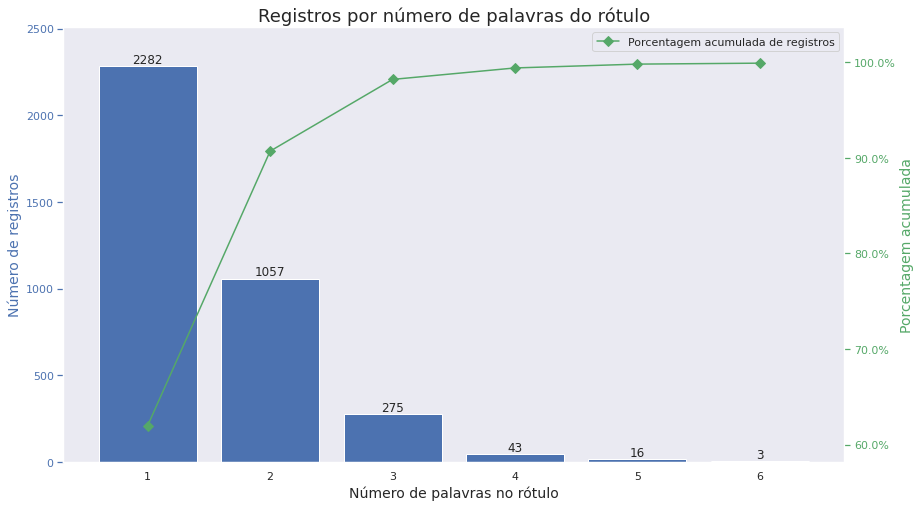

In [20]:
def Pareto(df, Type, Count, CumPercent):
    # Cria o barplot e define os dados os eixos, a cor das barras, titulo do gráfico
    fig, ax = plt.subplots(figsize=(14,8))
    bar = ax.bar(df[Type], df[Count])
    ax.set_title("Registros por número de palavras do rótulo")

    # Eixo secundário
    ax2 = ax.twinx()

    # Cria a Curva de Pareto no eixo secundário
    ax2.plot(df[Type], df[CumPercent], color="g", marker="D", ms=7, label='Porcentagem acumulada de registros')
    ax2.yaxis.set_major_formatter(PercentFormatter())

    # Configurações dos eixos
    ax.set_xlabel("Número de palavras no rótulo")
    ax.tick_params(axis="y", colors="b")
    ax.set_ylabel("Número de registros", color="b")
    ax.bar_label(bar)
    ax.margins(y=0.1)
    
    ax2.tick_params(axis="y", colors="g")
    ax2.set_ylabel("Porcentagem acumulada", color="g")
    ax2.margins(y=0.1)
    
    plt.legend(loc='upper right') # para mostrar a legenda
    
    # Finalmente mostra o grafico definido acima
    plt.show()

Pareto(palavras_tag[:6], 'Palavras na Tag', 'Número de Registros', '%Registros Acumulados')

Aqui é uma avaliação um pouco subjetiva, mas como visto no gráfico de Pareto, a maioria dos registros de rótulos (mais de 99%) possui até 4 palavras, o que cumpre com a especificação de um *rótulo*. 

É possível que os *outliers* (rótulos que contenham *muitas* palavras) não sejam termos que cumpram a função de *rótulo*.

#### 0.3.2.5 Atributo *timestamp*

In [21]:
# Verificação do intervalo de datas
# De acordo com a especificação, os rótulos devem estar entre 29/03/1996 e 24/09/2018
data_minima = pd.to_datetime('1996-03-29 00:00:00')
data_maxima = pd.to_datetime('2018-09-24 23:59:59')

tags_data_minima = pd.to_datetime(min(tags_df.timestamp), unit='s', origin='unix')
tags_data_maxima = pd.to_datetime(max(tags_df.timestamp), unit='s', origin='unix')

assert tags_data_minima > data_minima, 'Existe data mais antiga em tags do que o esperado'
assert tags_data_maxima < data_maxima, 'Existe data mais recente em tags do que o esperado'

print(f'Datas dos rótulos entre {tags_data_minima} e {tags_data_maxima} estão dentro do esperado')

Datas dos rótulos entre 2006-01-13 19:09:12 e 2018-09-16 11:50:03 estão dentro do esperado


O registro mais antigo de rótulo é do ano de 2006, ou seja, quase uma década após os primeiros registros de avaliações. O intervalo de tempo em que os rótulos foram registrados é consideravelmente menor comparado ao intervalo de tempo dos registros de avaliações.

#### 0.3.2.6 Duplicações

In [22]:
# Verificando se um mesmo usuário atribuiu um determinado rótulo mais de uma vez para um determinado filme
rotulos_duplicados = tags_df[tags_df.duplicated(subset=['userId', 'movieId', 'tag'])]

assert len(rotulos_duplicados) == 0, 'Existem rótulos duplicados'

print('Nenhuma rótulo duplicado no dataset')

Nenhuma rótulo duplicado no dataset


### 0.3.3 Dataset *Movies*

#### 0.3.3.1 Linhas e Colunas

In [23]:
# Verificação do número de linhas e lista de colunas, de acordo com a especificação do dataset
linhas_esperadas = 9742
colunas_esperadas = ['movieId', 'title', 'genres']

(num_linhas, num_colunas) = movies_df.shape
lista_colunas = list(movies_df.columns)

assert num_linhas == linhas_esperadas, 'Número de linhas não condiz com o esperado'
assert num_colunas == len(colunas_esperadas), 'Número de colunas não condiz com o esperado'
assert lista_colunas == colunas_esperadas, 'Colunas inconsistentes com o esperado'

print(f'Número de linhas `{num_linhas}` e lista de colunas `{lista_colunas}` do DataFrame Movies estão corretos')

Número de linhas `9742` e lista de colunas `['movieId', 'title', 'genres']` do DataFrame Movies estão corretos


In [24]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Não há valores nulos em nenhum atributo de nenhum registro do DataFrame *movies*

O tipo de todos os atributos é condizente com o que esperamos:
- **movieId** é *inteiros*, como esperado para Ids
- **title** é *object*, conforme esperado, pois os títulos são *strings*
- **genres** é *object*, conforme esperado, pois os gêneros são *strings*

#### 0.3.3.2 Atributo *movieId*

In [25]:
# Verificação quantidade de filmes
filmes_esperados = 9742

num_filmes = len(movies_df.movieId.unique())

assert num_filmes == filmes_esperados, 'Número de filmes não condiz com o esperado'

print(f'Número de filmes `{num_filmes}` no DataFrame está correto de acordo com a especificação')

Número de filmes `9742` no DataFrame está correto de acordo com a especificação


#### 0.3.3.3 Atributo *title*

In [26]:
# Verificação dos títulos
# Como títulos são strings, vamos verificar se possuem alguma repetição ou valor vazio

duplicados = movies_df[movies_df.title.duplicated()]
vazios = movies_df[movies_df.title == '']

print(f'Existe `{len(duplicados)}` filmes com títulos duplicados. E `{len(vazios)}` com título vazio')

Existe `5` filmes com títulos duplicados. E `0` com título vazio


#### 0.3.3.4 Atributo *genres*

In [27]:
# Verificação da lista de gêneros de filme
generos_esperados = [
    "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir",
    "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western", "(no genres listed)"
]

# Separa o campo genres em uma lista de gêneros
lista_generos = movies_df.genres.str.split("|")

# Transforma a lista de listas de gêneros em uma só Series com todos os valores
# https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173
todos_generos = pd.Series([x for _list in lista_generos for x in _list])

# Vamos verificar se os gêneros no nosso dataset estão todos dentro da lista esperada
try:
    assert set(todos_generos.unique()).issubset(generos_esperados), 'Existe gêneros que não são esperados'
except Exception as e:
    print(type(e), e)
    
# Quais gêneros não são esperados?
print('Gêneros no dataset diferentes do esperado:', np.setdiff1d(todos_generos, generos_esperados))

<class 'AssertionError'> Existe gêneros que não são esperados
Gêneros no dataset diferentes do esperado: ['Children' 'IMAX']


Existem dois gêneros presentes no *dataset* que não são esperados, de acordo com a especificação: **Children** e **IMAX**

No caso de **Children**, parece que houve um erro na especificação do *dataset*. Vamos sustituir o valor esperado de **Children's** para **Children**

In [28]:
try:
    generos_esperados[generos_esperados.index("Children's")] = "Children"
except:
    print("Children's já foi substituido. Continuando...")
    
print('Gêneros no dataset diferentes do esperado:', np.setdiff1d(todos_generos,generos_esperados))

Gêneros no dataset diferentes do esperado: ['IMAX']


Agora só temos o gênero **IMAX** que não está especificiado.

Vamos ver quantas vezes ele ocorre

In [29]:
(todos_generos == 'IMAX').sum()

158

### 0.3.4 Dataset *Links*

Os atributos deste dataset não nos parecem necessários para as análises desejadas. Desta forma, iremos desconsiderá-lo a partir de agora.

### 0.3.5 Relações entre Datasets

#### 0.3.5.1 Atributo *userId* em `ratings` e `tags`

In [30]:
# Verificar se os usuários de tags são um subconjunto dos usuários de ratings,
# uma vez que este possui a lista completa de usuários

usuarios_ratings = ratings_df.userId.unique()
usuarios_tags = tags_df.userId.unique()

assert set(usuarios_tags).issubset(set(usuarios_ratings)), 'Existem usuários em `tags` que não estão presentes em `ratings`'

print(f'Os {len(usuarios_tags)} usuários em `tags` são um subconjunto dos {len(usuarios_ratings)} usuários em `ratings`')

Os 58 usuários em `tags` são um subconjunto dos 610 usuários em `ratings`


#### 0.3.5.2 Atributo *movieId* em `ratings`, `tags` e `movies`

In [31]:
# Verificar se os Ids de filmes em ratings e tags são um subconjunto dos filmes em movies

filmes_ratings = ratings_df.movieId.unique()
filmes_tags = tags_df.movieId.unique()
filmes_movies = movies_df.movieId.unique()

assert set(filmes_ratings).issubset(set(filmes_movies)), 'Existem filmes em `ratings` que não estão presentes em `movies`'
assert set(filmes_tags).issubset(set(filmes_movies)), 'Existem filmes em `tags` que não estão presentes em `movies`'

print(f'Os {len(filmes_ratings)} filmes em `ratings` e os {len(filmes_tags)} em `tags` são um subconjunto dos {len(filmes_movies)} filmes do DataFrame `movies`')

Os 9724 filmes em `ratings` e os 1572 em `tags` são um subconjunto dos 9742 filmes do DataFrame `movies`


In [32]:
# Verificar se todos os filmes em movies receberam ao menos uma avaliação ou rótulo

assert set(np.concatenate((filmes_ratings, filmes_tags))) == set(movies_df.movieId), 'Conjunto de movieId nos DataFrames `ratings` e `tags` difere dos Ids no DataFrame `movies`'

print('A união dos conjuntos de movieId nos DataFrames `ratings` e `tags` é igual ao conjunto dos filmes no DataFrame `movies`')

A união dos conjuntos de movieId nos DataFrames `ratings` e `tags` é igual ao conjunto dos filmes no DataFrame `movies`


# 1. Pré-processamento

## 1.1 Conversão do timestamp em *ratings* e *tags* para `datetime`

In [33]:
ratings_df.timestamp = pd.to_datetime(ratings_df.timestamp, unit='s')

In [34]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51


In [35]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  int64         
 1   movieId    100836 non-null  int64         
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.1 MB


In [36]:
tags_df.timestamp = pd.to_datetime(tags_df.timestamp, unit='s')

In [37]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   userId     3683 non-null   int64         
 1   movieId    3683 non-null   int64         
 2   tag        3683 non-null   object        
 3   timestamp  3683 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 115.2+ KB


## 1.2 Rótulos com muitas palavras

In [38]:
tags_df[lista_palavras.apply(len) > 4]

,userId,movieId,tag,timestamp
412,106,4896,Everything you want is here,2016-07-03 17:29:04
485,161,52287,Something for everyone in this one... saw it w...,2007-04-13 21:14:21
587,318,48698,the catholic church is the most corrupt organi...,2010-06-08 14:09:49
621,319,364,Oscar (Best Music - Original Score),2016-04-22 19:05:19
739,424,608,based on a true story,2016-03-13 20:28:02
840,424,3186,based on a true story,2016-03-13 05:13:22
1112,474,457,based on a TV show,2006-01-20 19:18:37
1164,474,648,based on a TV show,2006-01-24 21:19:44
1181,474,818,based on a TV show,2006-01-16 01:46:36
1201,474,912,start of a beautiful friendship,2006-01-14 01:31:59


Optaremos por não remover nenhum rótulo, mesmo com mais de 4 palavras

## 1.3 Títulos duplicados

Listagem de filmes com títulos duplicados e o número de avaliações e rótulos que cada um possui

In [39]:
# Filmes com título repetidos
filmes_duplicados = movies_df[movies_df.title.duplicated(keep=False)].set_index('movieId')

# Quantidade de avaliações de cada filme duplicado
ratings_filmes_duplicados = ratings_df.query('movieId in @filmes_duplicados.index').movieId.value_counts().rename('Número de Avaliações')

# Quantidade de tags de cada filme duplicado
tags_filmes_duplicados = tags_df.query('movieId in @filmes_duplicados.index').movieId.value_counts().rename('Número de Tags')

duplicacoes = pd.concat([filmes_duplicados, ratings_filmes_duplicados, tags_filmes_duplicados], axis=1).fillna(0).sort_values(by='title')
duplicacoes

,title,genres,Número de Avaliações,Número de Tags
6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller,15,1.0
144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller,1,0.0
838,Emma (1996),Comedy|Drama|Romance,30,1.0
26958,Emma (1996),Romance,1,0.0
32600,Eros (2004),Drama,1,0.0
147002,Eros (2004),Drama|Romance,1,0.0
2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller,4,0.0
168358,Saturn 3 (1980),Sci-Fi|Thriller,1,0.0
34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller,50,0.0
64997,War of the Worlds (2005),Action|Sci-Fi,2,0.0


Para evitar problemas de separação de dados, vamos remover os títulos duplicados. Para que as avaliações e rótulos dos títulos duplicados não sejam perdidos, vamos converter os Ids dos filmes duplicados nos DataFrames de *ratings* e *tags* conforme relação abaixo:

    Confessions of a Dangerous Mind (2002) - movieId: 6003 (old: 144606)
    Emma (1996) - movieId: 838 (old: 26958)
    Eros (2004) - movieId: 32600 (old: 147002)
    Saturn 3 (1980) - movieId: 2851 (old: 168358)
    War of the Worlds (2005) - movieId: 34048 (old:64997)

In [40]:
# Dicionário de chaves de movieId a serem excluídos e valores dos movieIds correspondentes
movieId_correspondentes = {
    144606: 6003,
    26958: 838,
    147002: 32600,
    168358: 2851,
    64997: 34048
}

# Função de conversão
def conversao_movieId(num):
    return movieId_correspondentes[num] if num in movieId_correspondentes else num

# Conversão de movieIds no DF ratings
ratings_df['movieId'] = ratings_df['movieId'].map(conversao_movieId)

# Conversão de movieIds no DF tags
tags_df['movieId'] = tags_df['movieId'].map(conversao_movieId)

# Remoção dos filmes com título duplicado no DF movies
movies_df = movies_df.query('movieId not in @movieId_correspondentes.keys()')

# Verifica se não há mais duplicações de títulos e se todos os registros em ratings e tags foram substituídos corretamente
assert movies_df.title.duplicated().sum() == 0, 'Existem filmes com título duplicado'
assert len(ratings_df.query('movieId in @movieId_correspondentes.keys()')) == 0, 'Existem registros com movieId excluído no DataFrame ratings'
assert len(tags_df.query('movieId in @movieId_correspondentes.keys()')) == 0, 'Existem registros com movieId excluído no DataFrame tags'

# Verifica se o número de avaliações e de tags está correto.
# Os movieIds que permaneceram devem ter tantas avaliações e tags quanto a soma dos dois moviIds que foram unificados

# Soma do número de avaliações e de tags dos filmes com títulos duplicados
totais_duplicacoes = duplicacoes[['title', 'Número de Avaliações', 'Número de Tags']].groupby(by='title').sum()

# Quantidade de avaliações e rótulos por filme
totais_filmes = pd.concat([
    movies_df.set_index('movieId'),
    ratings_df.movieId.value_counts().rename('ratings'),
    tags_df.movieId.value_counts().rename('tags')
], axis=1).fillna(0).set_index('title')

# Concatenação dos registros com a soma de avaliações e rótulos dos filmes duplicados
# com os novos valores desta contagem após a unificação dos títulos duplicados
totais = pd.concat([totais_duplicacoes, totais_filmes], join='inner', axis=1)

assert ((totais['Número de Avaliações'] != totais.ratings) | (totais['Número de Tags'] != totais.tags)).sum() == 0, 'Número de avaliações ou rótulos difere da soma dos títulos duplicados'

## 1.4 Gêneros não especificados
### 1.4.1 IMAX

In [41]:
# Separar os generos por colunas
generos = movies_df['genres'].str.get_dummies()

# Juntar informações do movies_df com os generos separados por coluna
movies_df_generos = pd.concat([movies_df, generos], axis=1)
movies_df_generos.drop('genres', axis=1, inplace=True)

print(f'Quantidade de filmes com genero IMAX: {movies_df_generos.query("IMAX == 1").shape[0]}\n\n')
movies_df_generos.query("IMAX == 1").head()

Quantidade de filmes com genero IMAX: 158




,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
123,150,Apollo 13 (1995),0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
322,364,"Lion King, The (1994)",0,0,1,1,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0
512,595,Beauty and the Beast (1991),0,0,0,1,1,0,0,0,...,0,0,1,1,0,1,0,0,0,0
1328,1797,Everest (1998),0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2381,3159,Fantasia 2000 (1999),0,0,0,1,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0


Embora o genero IMAX não esteja listado na documentação do dataset, essa informação não altera as análises. Dessa forma o genero IMAX será tratado como um genero válido

## 1.5 Decisões

- **Quantidade de dados**: Todos os *datasets* possuem todas as colunas completas.
- **Tipo de dados**: Conversão do atributo *timestamp* para `datetime`, todos os demais dados estão com o formato correto.
- **Outliers**:
  - Tag: Optamos por não remover nenhuma tag
- **Tratamento dos dados**:
  - Filmes Duplicados: 5 filmes estavam com o título duplicado - Optou-se por unificar os id para evitar problemas de análises
  - Gêneros: O gênero *IMAX* não constava na documentação do arquivo, optou-se por manter essa informação, como um gênero válido

# 2. Análise Exploratória

## 2.1 Existe alguma correlação entre o ano de lançamento do filme e sua avaliação média (média de ratings)?

In [83]:
ano_movies = movies_df.copy()

# Separar o ano do titulo
ano_movies['ano'] = ano_movies['title'].str.split('(').str.get(-1).str.split(')').str.get(0)

# Converter ano para valor numérico
ano_movies['ano'] = pd.to_numeric(ano_movies['ano'], errors='coerce')

# Verificar tipo de dados
ano_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9737 entries, 0 to 9741
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9737 non-null   int64  
 1   title    9737 non-null   object 
 2   genres   9737 non-null   object 
 3   ano      9724 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 380.4+ KB


In [84]:
# Filmes sem ano definido
filmes_sem_ano = ano_movies[ano_movies['ano'].isna()]
print(f'Existem {filmes_sem_ano.shape[0]} filmes sem a informação do ano\n\n')
filmes_sem_ano

Existem 13 filmes sem a informação do ano




,movieId,title,genres,ano
6059,40697,Babylon 5,Sci-Fi,NaN
9031,140956,Ready Player One,Action|Sci-Fi|Thriller,NaN
9091,143410,Hyena Road,(no genres listed),NaN
9138,147250,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed),NaN
9179,149334,Nocturnal Animals,Drama|Thriller,NaN
9259,156605,Paterson,(no genres listed),NaN
9367,162414,Moonlight,Drama,NaN
9448,167570,The OA,(no genres listed),NaN
9514,171495,Cosmos,(no genres listed),NaN
9515,171631,Maria Bamford: Old Baby,(no genres listed),NaN


In [88]:
# Remover os filmes sem ano definido
ano_movies.dropna(subset=['ano'], inplace=True)

# Converter o ano para 'integer'
ano_movies['ano'] = ano_movies['ano'].astype('int')
ano_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9724 entries, 0 to 9741
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9724 non-null   int64 
 1   title    9724 non-null   object
 2   genres   9724 non-null   object
 3   ano      9724 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 379.8+ KB


### 2.1.1 Avaliação média e ano de lançamento de cada filme

In [91]:
# Calcular a avaliação média de cada filme
rating_movie = ratings_df.groupby('movieId').mean()['rating']

# Juntando o ano com as notas
rating_ano_movies = ano_movies[['movieId', 'ano']].merge(rating_movie, left_on='movieId', right_index=True).set_index('movieId')

print(f'{len(rating_ano_movies)} registros de filmes possuem ano de lançamento e avaliação média')
rating_ano_movies.head()

9706 registros de filmes possuem ano de lançamento e avaliação média


,ano,rating
movieId,,
1,1995,3.920930
2,1995,3.431818
3,1995,3.259615
4,1995,2.357143
5,1995,3.071429


In [92]:
# Calcular a correlação entre ano e rating
rating_ano_movies.corr().round(3)

,ano,rating
ano,1.000,-0.111
rating,-0.111,1.000


Segundo a [Tabela do Coeficiente de Correlação de Pearson](https://pt.wikipedia.org/wiki/Coeficiente_de_correla%C3%A7%C3%A3o_de_Pearson), a correlação entre o ano de lançamento do filme e sua nota média é de **-0,111**, podendo ser considerada desprezível.

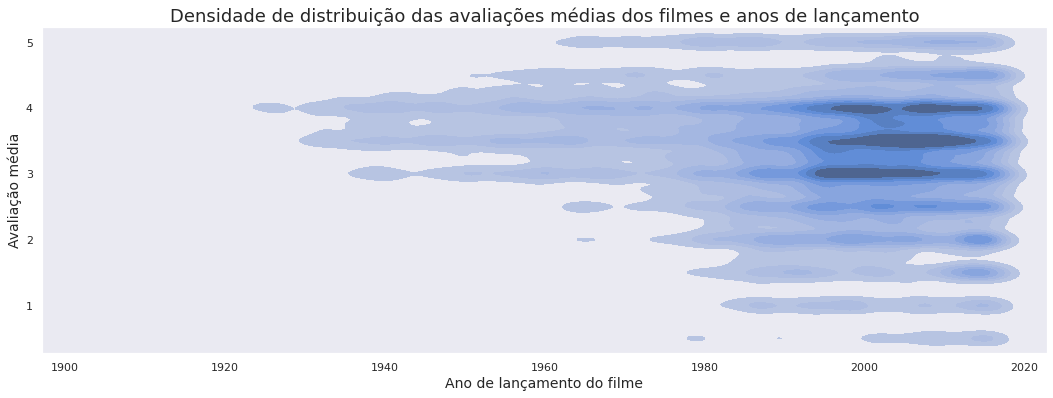

In [96]:
plt.figure(figsize=(18,6))
ax = sns.kdeplot(data=rating_ano_movies, x='ano', y='rating', shade=True, bw_adjust=0.4)
ax.set_xlabel('Ano de lançamento do filme')
ax.set_ylabel('Avaliação média')

plt.title('Densidade de distribuição das avaliações médias dos filmes e anos de lançamento')
plt.show()

O gráfico de densidade indica que os filmes lançados **antes da década de 70** tendem a ter uma concentração de avaliações médias entre **3 e 4,5 estrelas**. A partir de então, as avalições médias ficam mais espalhadas, avaliações médias abaixo de 3 estrelas passas a ser mais comuns. **A partir da década de 80**, então, as avaliações passam a ocupar, majoritariamente, o intervalo entre **1,5 e 4,5 estrelas**.

Porém, podemos ver que ao longo de **todo o o período**, a maior parte das avaliações estão concentradas **entre 3 e 4 estrelas**.

### 2.1.2 Avaliações médias dos filmes agrupados por ano de lançamento

In [97]:
# Juntando o ano com as notas
rating_ano_movies = ratings_df[['movieId', 'rating']].merge(ano_movies[['movieId', 'ano']], on='movieId')

print(f'{len(rating_ano_movies)} registros de avaliação, agrupados com o ano de lançamento do filme')
rating_ano_movies.head()

100818 registros de avaliação, agrupados com o ano de lançamento do filme


,movieId,rating,ano
0,1,4.0,1995
1,1,4.0,1995
2,1,4.5,1995
3,1,2.5,1995
4,1,4.5,1995


In [98]:
# Criando um DF com a média das notas por ano
rating_medio_por_ano = rating_ano_movies[['ano', 'rating']].groupby('ano').mean()
rating_medio_por_ano['count'] = rating_ano_movies[['ano', 'rating']].groupby('ano').count()
rating_medio_por_ano = rating_medio_por_ano.rename_axis('ano').reset_index()

print(f'{len(rating_medio_por_ano)} registros de avaliação média e número de avaliações por ano de lançamento do filme')
rating_medio_por_ano.head()

106 registros de avaliação média e número de avaliações por ano de lançamento do filme


,ano,rating,count
0,1902,3.5,5
1,1903,2.5,2
2,1908,4.0,1
3,1915,2.0,1
4,1916,3.6,5


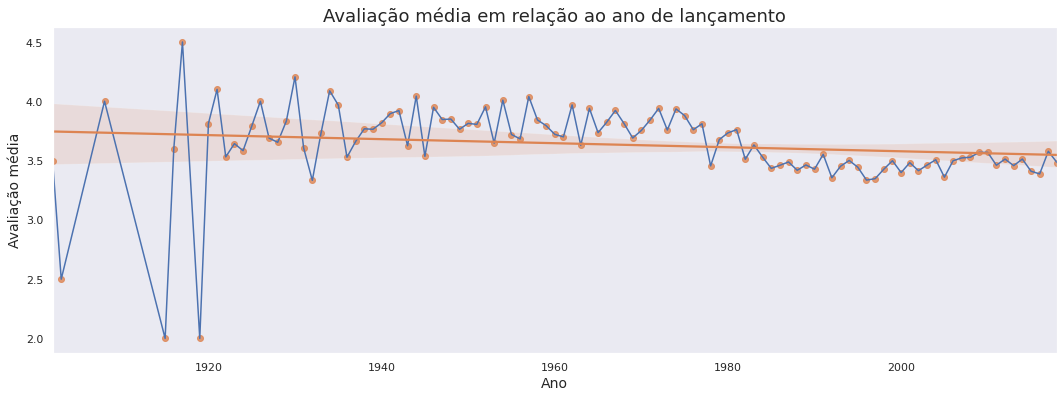

In [100]:
plt.figure(figsize=(18,6))

# Gráfico de linhas
sns.lineplot(x = 'ano', y = 'rating', data = rating_medio_por_ano)

# Reta de regressão
ax = sns.regplot(x = 'ano', y = 'rating', data = rating_medio_por_ano)

ax.set(ylabel = 'Avaliação média', xlabel = 'Ano', title='Avaliação média em relação ao ano de lançamento')
plt.show()

O gráfico da nota média dos filmes por ano de lançamento não indica uma tendência significativa ao longo do tempo. Podemos observar apenas que, em média, as notas médias dos filmes das **décadas de 40 a 80** estão majoritariamente **acima da reta de regressão** dos pontos. Já as notas médias dos filmes lançados **a partir da década de 80** tendem a ser **menores que os valores preditos** pela regressão linear. A reta de regressão apresenta uma leve inclinação negativa.

In [101]:
# Coeficiente de Correlação
rating_medio_por_ano.corr().round(3)

,ano,rating,count
ano,1.000,-0.158,0.667
rating,-0.158,1.000,-0.289
count,0.667,-0.289,1.000


Segundo a Tabela do Coeficiente de Correlação de Pearson, a correlação entre o ano de lançamento do filme e as notas médias é de **-0,158**, podendo ser considerada desprezível.

## 2.2 Qual o grupo mais disperso, o de usuários que avaliaram ou o de usuários que rotularam filmes?


O critério que vamos usar para comparar a dispersão entre os dois grupos será da quantidade de avaliações e rótulos inseridos por cada usuário

In [52]:
# Criando os DF de userId pela quantidade de vezes que o usuário avaliou um filme
userId_quantidade_de_ratings = ratings_df[['userId','movieId']].groupby('userId').count().rename(columns={'movieId': 'Ratings'})

# Criando os DF de userId pela quantidade de vezes que o usuário rotulou um filme
userId_quantidade_de_tags = tags_df[['userId','movieId']].groupby('userId').count().rename(columns={'movieId': 'Tags'})

userId_quantidade_ratings_tags = pd.concat([userId_quantidade_de_ratings, userId_quantidade_de_tags], axis=1).fillna(0).astype('int')

print(f'{len(userId_quantidade_ratings_tags)} registros de usuários e respectivas quantidades de avaliações e rótulos inseridos')
userId_quantidade_ratings_tags.head()

610 registros de usuários e respectivas quantidades de avaliações e rótulos inseridos


,Ratings,Tags
userId,,
1,232,0
2,29,9
3,39,0
4,216,0
5,44,0


In [53]:
# Estatísticas descritivas para o conjunto de número de avaliações por usuário
ratings_summary = userId_quantidade_de_ratings.describe()
# Coeficiente de Variação = std / mean
ratings_summary.loc['CV'] = stats.variation(userId_quantidade_de_ratings)
# Amplitude Interquartil
ratings_summary.loc['IQR'] = stats.iqr(userId_quantidade_de_ratings)

# Estatísticas descritivas para o conjunto de número de rótulos por usuário
tags_summary = userId_quantidade_de_tags.describe()
tags_summary.loc['CV'] = stats.variation(userId_quantidade_de_tags)
tags_summary.loc['IQR'] = stats.iqr(userId_quantidade_de_tags)

ratings_tags_summary = pd.concat([ratings_summary, tags_summary], axis=1)
ratings_tags_summary.round(3)

,Ratings,Tags
count,610.000,58.000
mean,165.305,63.500
std,269.481,215.118
min,20.000,1.000
25%,35.000,2.250
50%,70.500,4.000
75%,168.000,13.000
max,2698.000,1507.000
CV,1.629,3.358
IQR,133.000,10.750


Um total de 610 usuários realizaram avaliações de filmes. Em média, cada usuário realizou 165 avaliações, com um desvio padrão de 269.<br />
Um total de 58 usuários rotularam filmes. Em média, cada usuário rotulou 63 filmes, com um desvio padrão de 215.

Considerando o [Coeficiente de Variação](https://pt.wikipedia.org/wiki/Coeficiente_de_varia%C3%A7%C3%A3o) (CV), poderíamos dizer que o grupo de usuários que rotularam filmes tem um *Desvio Padrão Relativo à Média* maior do que dos usuários que avaliaram filmes, podendo indicar uma maior dispersão.

Por sua vez, a medida de [Amplitude Interquartil](https://en.wikipedia.org/wiki/Interquartile_range) (IQR) indica que os 50% dos valores medianos de avaliações estão mais dispersos que os 50% dos valores medianos dos rótulos. Por este outro critério, concluiríamos que o conjunto de usuários que avaliaram filmes são mais dispersos.

O fato de a distância entre a média e a mediana no conjunto de rótulos ser muito maior do que a distância entre estas medidas no conjunto de avaliações indica uma maior influência dos *outliers* no conjunto de rótulos. Desta forma, nos parece que uma medida mais robusta, como o IQR, poderia ser mais adequado para comparar a dispersão entre os conjuntos.

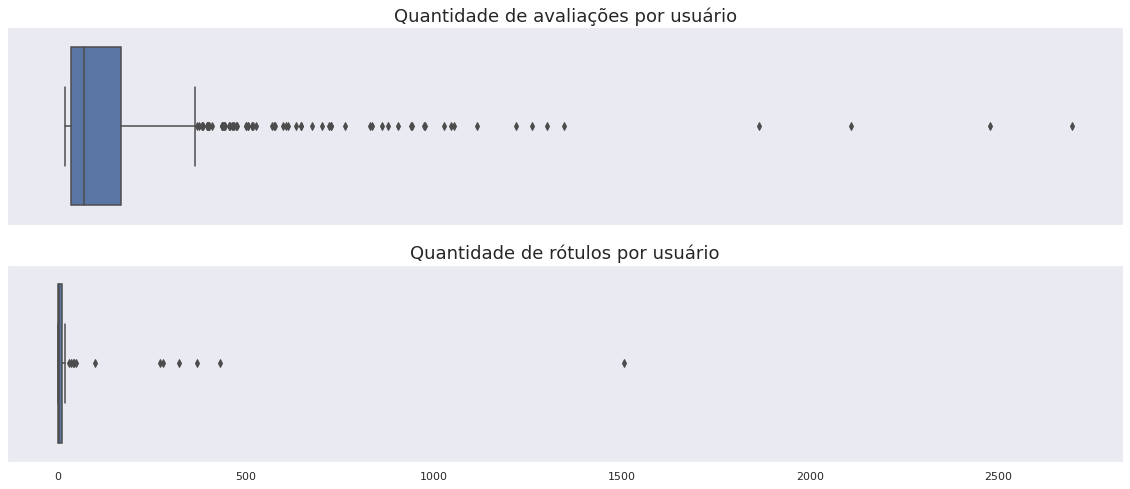

In [54]:
fig, axs = plt.subplots(2, sharex=True, figsize=(20,8))

sns.boxplot(x=userId_quantidade_de_ratings.Ratings, ax=axs[0])
axs[0].set_title('Quantidade de avaliações por usuário')
axs[0].set_xlabel('')

sns.boxplot(x=userId_quantidade_de_tags.Tags, ax=axs[1])
axs[1].set_title('Quantidade de rótulos por usuário')
axs[1].set_xlabel('')

plt.show()

A análise dos *boxplots* confirma que o conjunto de usuários que rotularam filmes em sua maioria realizou poucas rotulagens (75% dos usuários rotularam 13 ou menos filmes). Os *outliers* deste conjunto são muito influentes, tendo alguns pontos muito distantes do conjunto de dados (como o usuário que rotulou mais de 1.500 filmes), o que distorce sobremaneira a média do conjunto para 63,5 rótulos por usuário. Outro fator para a grande influência de *outliers* é que o conjunto possui um número de amostras signifcativamente menor do que o conjunto de usários avaliadores.

O *boxplot* de quantidade de avaliações por usuários indica que entre a maioria dos usuários avaliadores há uma disperão maior do que no caso de rótulos. Apesar de existirem também *outliers*, a distância destes para o conjunto de dados é menos significativa que no caso anterior e, portanto, a média e mediana estão mais próximas. Minimizando o efeito dos *outliers*, poderíamos dizer que este grupo de usuários avaliadores é mais disperso, no geral, do que o grupo de usuários que rotularam filmes.

Vamos padronizar os valores dos conjuntos (calculando o [z-score](https://en.wikipedia.org/wiki/Standard_score)), que nos dará uma melhor base de comparação.

In [55]:
# Cálculo do z-score para os registros de ratings (z = (x - mean)/std)
userId_score_ratings = userId_quantidade_de_ratings.copy();
userId_score_ratings['Z-score ratings'] = stats.zscore(userId_score_ratings.Ratings)

#z-score para os registros de tags
userId_score_tags = userId_quantidade_de_tags.copy();
userId_score_tags['Z-score tags'] = stats.zscore(userId_score_tags.Tags)

# Estatísticas descritivas para a distribuição padronizada de quantidade de avaliações e rótulos por usuário.
# Não faz sentido calcular o CV pois a padronização implica em que a média dos dados será 0 (zero)
score_ratings_summary = userId_score_ratings[['Z-score ratings']].describe()
score_ratings_summary.loc['IQR'] = stats.iqr(userId_score_ratings['Z-score ratings'])

score_tags_summary = userId_score_tags[['Z-score tags']].describe()
score_tags_summary.loc['IQR'] = stats.iqr(userId_score_tags['Z-score tags'])

score_ratings_tags_summary = pd.concat([score_ratings_summary, score_tags_summary], axis=1)
score_ratings_tags_summary.round(3)

,Z-score ratings,Z-score tags
count,610.000,58.000
mean,0.000,-0.000
std,1.001,1.009
min,-0.540,-0.293
25%,-0.484,-0.287
50%,-0.352,-0.279
75%,0.010,-0.237
max,9.406,6.769
IQR,0.494,0.050


A padronização dos valores coloca na mesma escala os diferentes conjuntos. A tabela acima nos mostra que um usuário chegou a avaliar uma quantidade de filmes **9,4** desvios-padrões acima da média. Para os rótulos, o usuário que mais inseriu informações o fez em uma quantidade de registros aproximadamente **6,7** desvios-padrões da média. A amplitude interquartil é quase 10 vezes maior entre o grupo de avaliadores comparado ao grupo de rotuladores.

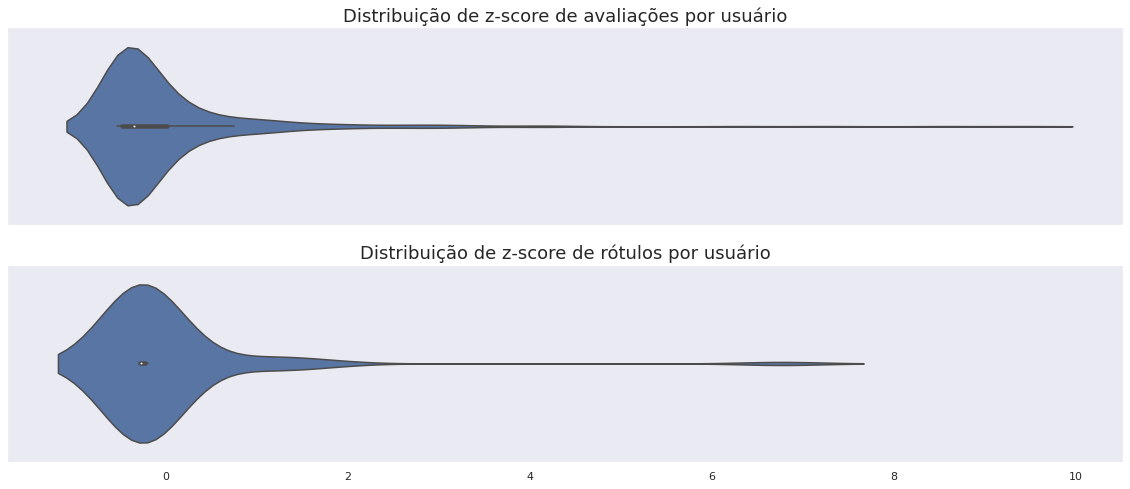

In [56]:
fig, axs = plt.subplots(2, sharex=True, figsize=(20,8))

sns.violinplot(x=userId_score_ratings['Z-score ratings'], ax=axs[0])
axs[0].set_title('Distribuição de z-score de avaliações por usuário')
axs[0].set_xlabel('')

sns.violinplot(x=userId_score_tags['Z-score tags'], ax=axs[1])
axs[1].set_title('Distribuição de z-score de rótulos por usuário')
axs[1].set_xlabel('')

plt.show()

Os *violinplot* para os dois grupos de usuários, na mesma escala, mostram mais claramente que o grupo de usuários que realizaram avaliação estão mais dispersos em relação à quantidade de filmes avaliados. O grupo de avaliadores apresenta uma maior **amplitude de valores** e uma **maior amplitude interquartil** quando ambos grupos estão padronizados para a mesma média e desvio padrão. 

## 2.3 Qual a categoria rotulada mais frequente?

In [108]:
# Dataframe de filmes com as categorias separadas por colunas
movies_df_generos.sample()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
4339,6338,Daddy Day Care (2003),0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
# Juntando o DF de categorias com a quantidade de tags usando movieId como chave
categorias_rotuladas = pd.concat([
    movies_df_generos.set_index('movieId'),
    tags_df[['movieId','tag']].groupby('movieId').count()
], axis = 1)
categorias_rotuladas.drop('title', axis = 1, inplace = True)
categorias_rotuladas.head(3)

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,tag
movieId,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3.0
2,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2.0


In [123]:
# Criando Dicionário relacionando Generos com quantidade de tags
qtd_tags_por_rotulos = {}
for i in categorias_rotuladas.columns[:-1]:
    qtd_tags_por_rotulos[i] = categorias_rotuladas[categorias_rotuladas[i] == 1]['tag'].sum()
    
# Transformando Dicionário em DF
qtd_tags_por_rotulos = pd.DataFrame(qtd_tags_por_rotulos.values(), index = qtd_tags_por_rotulos.keys(), columns = ['Tags'])
qtd_tags_por_rotulos.sort_values(by='Tags', ascending= False).head()

,Tags
Drama,2095.0
Comedy,1154.0
Thriller,1099.0
Action,837.0
Crime,800.0


A categoria Drama foi a mais rotulada com 2.095 Tags atribuidas

## 2.4 Como estão distribuídas as avaliações ao longo do tempo?

### 2.4.1 Número de avaliações e média das avaliações por mês

In [129]:
ratings_timestamp = ratings_df.groupby(pd.Grouper(key='timestamp',freq='M')).agg({'rating': ['mean','count']})
ratings_timestamp.columns = ['Média das avaliações', 'Número de avaliações']

print(f'{len(ratings_timestamp)} registros com a média e o total de avaliações em cada mês')
ratings_timestamp.head()

271 registros com a média e o total de avaliações em cada mês


,Média das avaliações,Número de avaliações
timestamp,,
1996-03-31,3.982759,58
1996-04-30,3.739394,165
1996-05-31,3.514423,832
1996-06-30,3.540204,883
1996-07-31,3.695297,489


In [130]:
ratings_timestamp.describe().round(2)

,Média das avaliações,Número de avaliações
count,267.00,271.00
mean,3.55,372.09
std,0.33,396.31
min,2.61,0.00
25%,3.37,99.00
50%,3.58,231.00
75%,3.77,516.00
max,4.62,2397.00


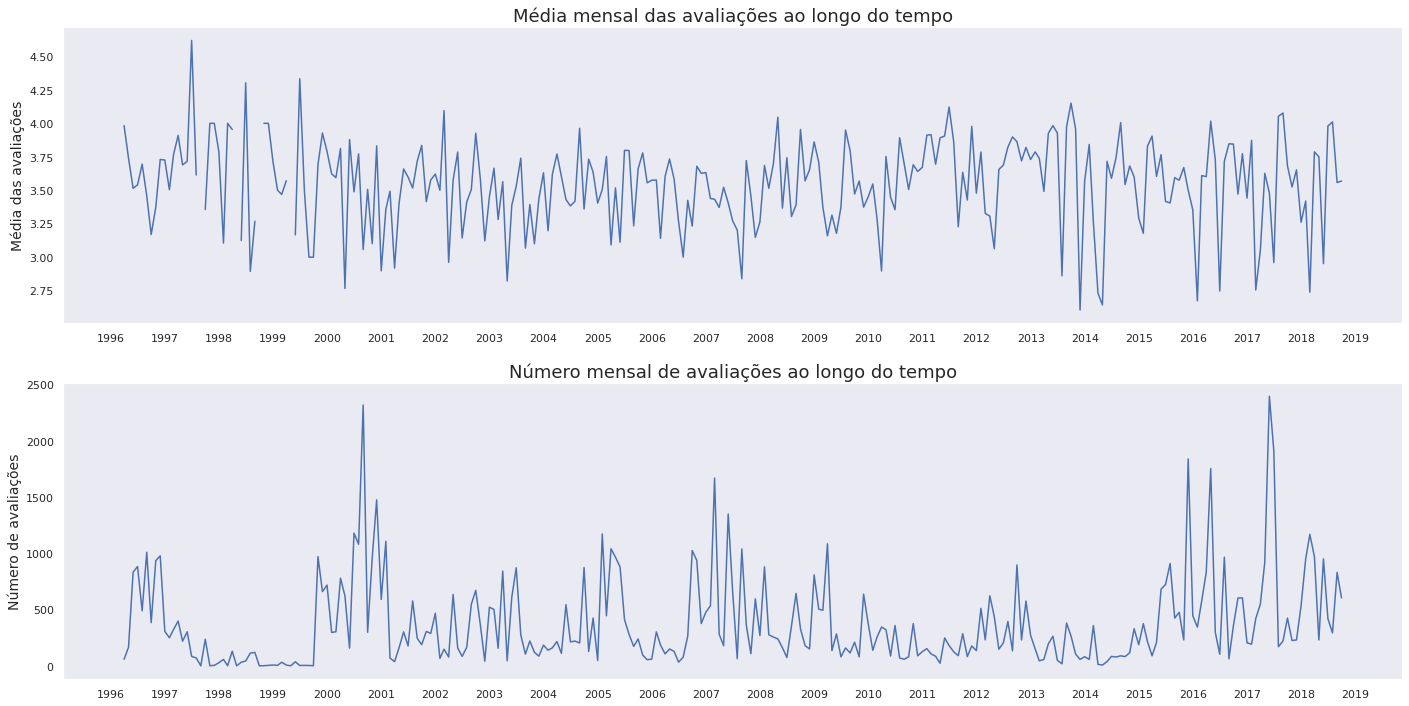

In [133]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(24,12))

# Gráfico da média das avaliações
ax1.plot(ratings_timestamp['Média das avaliações'])
ax1.set_title('Média mensal das avaliações ao longo do tempo')
ax1.set_ylabel('Média das avaliações')

# Rótulo anual para eixo x
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.YearLocator())

# Gráfico do número de avaliações
ax2.plot(ratings_timestamp['Número de avaliações'])
ax2.set_title('Número mensal de avaliações ao longo do tempo')
ax2.set_ylabel('Número de avaliações')

# Rótulo anual para eixo x
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.xaxis.set_major_locator(mdates.YearLocator())

plt.show()

Os gráficos de média e número de avaliações mensais ao longo do período **não indicam tendência ou sazonalidade**.

Mostram apenas que a **há uma grande variação a cada mês** tanto para a média quanto para o número de avaliações. Ou seja, a média das avaliações dos filmes varia de cerca de 2,6 em alguns meses até 4,6 em outros. Considerando o número de avaliações, há meses em que nenhuma avaliação foi realizada e outros em que quase 2.400 avaliações foram feitas.

### 2.4.2 Número de avaliações e média das avaliações por ano

In [134]:
# Número de avaliações e média das avaliações por ano
ratings_timestamp = ratings_df.groupby(pd.Grouper(key='timestamp',freq='Y')).agg({'rating': ['mean','count']})
ratings_timestamp.columns = ['Média das avaliações', 'Número de avaliações']

print(f'{len(ratings_timestamp)} registros com a média e o total de avaliações a cada ano')
ratings_timestamp.head()

23 registros com a média e o total de avaliações a cada ano


,Média das avaliações,Número de avaliações
timestamp,,
1996-12-31,3.535927,6040
1997-12-31,3.727557,1916
1998-12-31,3.435897,507
1999-12-31,3.772448,2439
2000-12-31,3.392506,10061


In [135]:
ratings_timestamp.describe().round(2)

,Média das avaliações,Número de avaliações
count,23.00,23.00
mean,3.54,4384.17
std,0.15,2418.73
min,3.31,507.00
25%,3.43,2370.00
50%,3.51,4059.00
75%,3.65,6229.00
max,3.88,10061.00


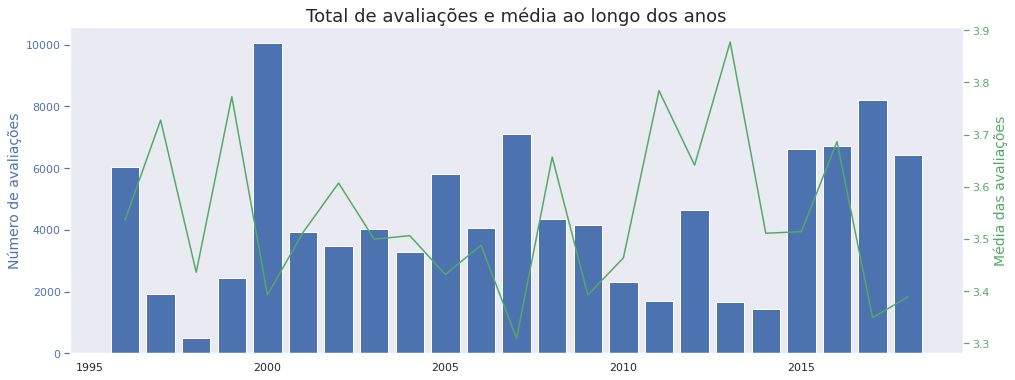

In [136]:
fig, ax = plt.subplots(figsize=(16,6))

# Gráfico de barras com o número de avaliações
ax.bar(ratings_timestamp.index.year, ratings_timestamp['Número de avaliações'])
ax.tick_params(axis="y", colors="b")
ax.set_ylabel("Número de avaliações", color="b")
ax.grid(False)

ax2 = ax.twinx()
ax2.plot(ratings_timestamp.index.year, ratings_timestamp['Média das avaliações'], color="g")
ax2.tick_params(axis="y", colors="g")
ax2.set_ylabel("Média das avaliações", color="g")

plt.title("Total de avaliações e média ao longo dos anos", fontsize=18)
plt.show()

Agrupando as avaliações por ano, também não conseguimos perceber **nenhuma tendência ou sazonalidade**.

Em termos de variação, o número de avaliações apresenta uma grande amplitude, com anos com pouco mais de 500 avaliações feitas e outros em que mais de 10 mil avaliações foram realizadas. A média das avaliações se apresenta um pouco mais homogênea, com menor amplitude (3,31 a 3,88).

A observação do gráfico acima parece indicar uma correlação entre o número anual de avaliações feitas e a média das avaliações naquele ano. Ou seja, parece que quanto mais avaliaçẽos feitas, menor é a média das avaliações. Vamos investigar isto melhor.

In [137]:
ratings_timestamp.corr()

,Média das avaliações,Número de avaliações
Média das avaliações,1.000000,-0.514578
Número de avaliações,-0.514578,1.000000


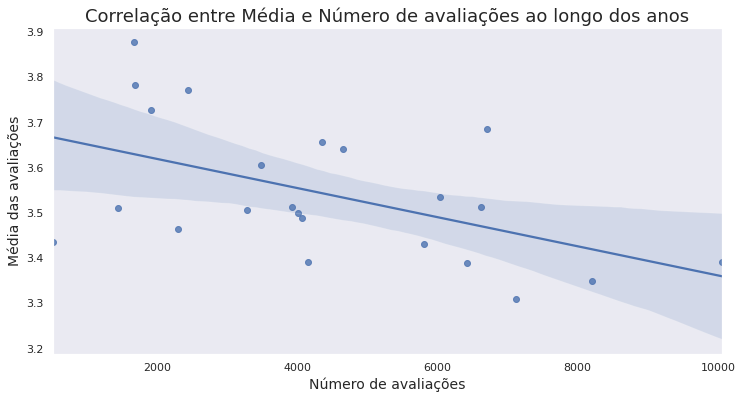

In [64]:
plt.figure(figsize=(12,6))

sns.regplot(data=ratings_timestamp, x='Número de avaliações', y='Média das avaliações')

plt.title('Correlação entre Média e Número de avaliações ao longo dos anos')
plt.show()

De fato o **coeficiente de correlação** (-0,51) e a **reta de regressão** mostram que existe uma tendência a médias de avaliação menores a medida em que o número de avaliações é maior. Apesar de que a variação para o intervalo de confiança de 95% traçado pelo `regplot` é bastante grande.

## 2.5 Qual a correlação entre a avaliação e a criação de rótulos entre os usuários?

### 2.5.1 Considerando todos os usuários

In [144]:
ratings_tags = pd.merge(
    ratings_df[['userId','rating']].groupby('userId').count(),
    tags_df[['userId','tag']].groupby('userId').count(),
    on='userId', how='outer'
).fillna(0).astype('int')

print(f'{len(ratings_tags)} registros de usuários com as respectivas quantidades de avaliações e rótulos (pondendo ser zero)')
ratings_tags.head()

610 registros de usuários com as respectivas quantidades de avaliações e rótulos (pondendo ser zero)


,rating,tag
userId,,
1,232,0
2,29,9
3,39,0
4,216,0
5,44,0


In [141]:
ratings_tags.corr().round(2)

,rating,tag
rating,1.00,0.36
tag,0.36,1.00


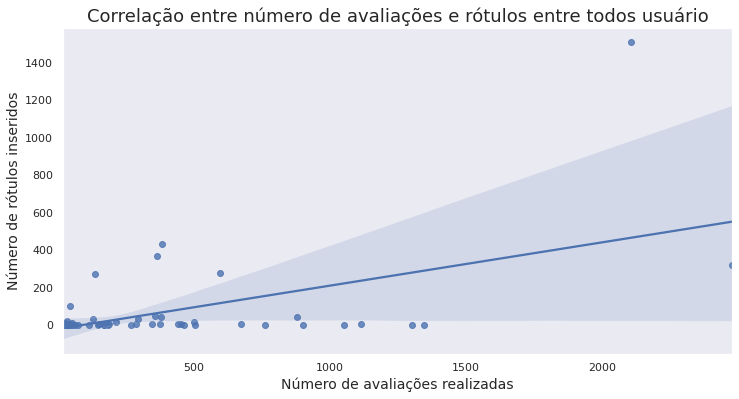

In [149]:
plt.figure(figsize=(12,6))

ax = sns.regplot(data=ratings_tags, x='rating', y='tag')
ax.set_xlabel('Número de avaliações realizadas')
ax.set_ylabel('Número de rótulos inseridos')

plt.title('Correlação entre número de avaliações e rótulos entre todos usuário')
plt.grid(False)
plt.show()

Segundo a [Tabela do Coeficiente de Correlação de Pearson](https://pt.wikipedia.org/wiki/Coeficiente_de_correla%C3%A7%C3%A3o_de_Pearson), a correlação de 0,36 é considerada fraca.

Como consideramos todos os usuários, a maioria não realizou nenhum rótulo, causando uma grande concentração no zero do eixo y do gráfico acima.

### 2.5.2 Considerando apenas os usuários que avaliaram e rotularam

In [145]:
ratings_tags = pd.merge(
    ratings_df[['userId','rating']].groupby('userId').count(),
    tags_df[['userId','tag']].groupby('userId').count(),
    on='userId', how='inner'
)

print(f'{len(ratings_tags)} registros de usuários com as respectivas quantidades de avaliações e rótulos (maiores que zero)')
ratings_tags.head()

58 registros de usuários com as respectivas quantidades de avaliações e rótulos (maiores que zero)


,rating,tag
userId,,
2,29,9
7,152,1
18,502,16
21,443,4
49,21,3


In [146]:
ratings_tags.corr().round(2)

,rating,tag
rating,1.00,0.54
tag,0.54,1.00


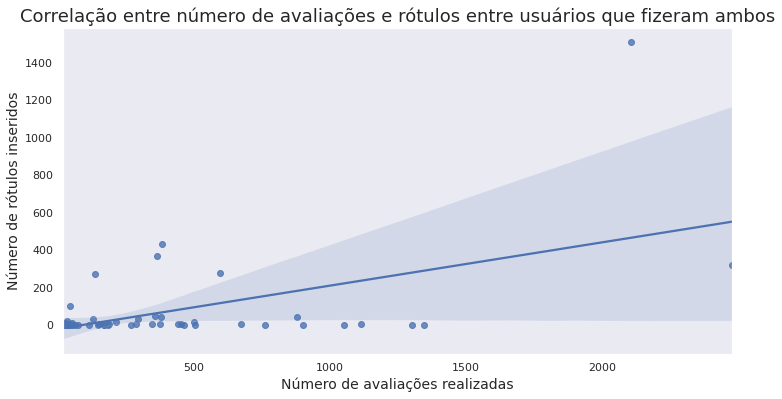

In [148]:
plt.figure(figsize=(12,6))

ax = sns.regplot(data=ratings_tags, x='rating', y='tag')
ax.set_xlabel('Número de avaliações realizadas')
ax.set_ylabel('Número de rótulos inseridos')

plt.title('Correlação entre número de avaliações e rótulos entre usuários que fizeram ambos')
plt.grid(False)
plt.show()

A correlação de 0,54 é considerada moderada, porém a incerteza nos dados é bastante grande, como visto pelo intervalo de confiança do gráfico acima.

## 2.6 Como é a distribuição das notas em relação aos filmes?

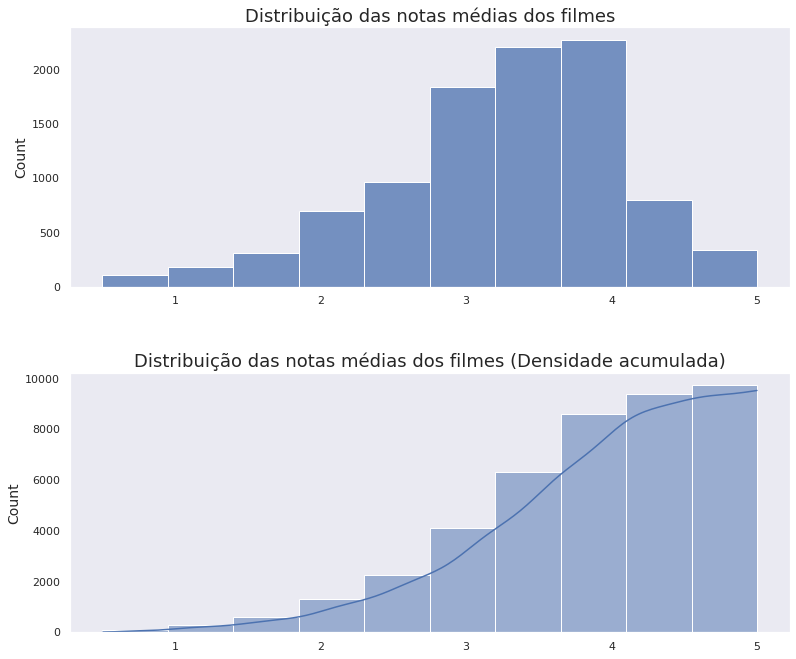

In [167]:
mean_rating = ratings_df[['movieId', 'rating']].groupby('movieId').mean()

fig = plt.figure(figsize=(10,8))

# Gráfico 1 - Histograma
eixo = fig.add_axes([0, 0.6, 1, 0.45])
eixo = sns.histplot(mean_rating, bins = 10)
eixo.set_title('Distribuição das notas médias dos filmes')
eixo.get_legend().remove()

# Gráfico 2 - Notas Acumuladas
eixo2 = fig.add_axes([0, 0, 1, 0.45])
eixo2 = sns.histplot(mean_rating, kde = True, bins = 10, cumulative = True)
eixo2.set_title('Distribuição das notas médias dos filmes (Densidade acumulada)',)
eixo2.get_legend().remove()

plt.show()

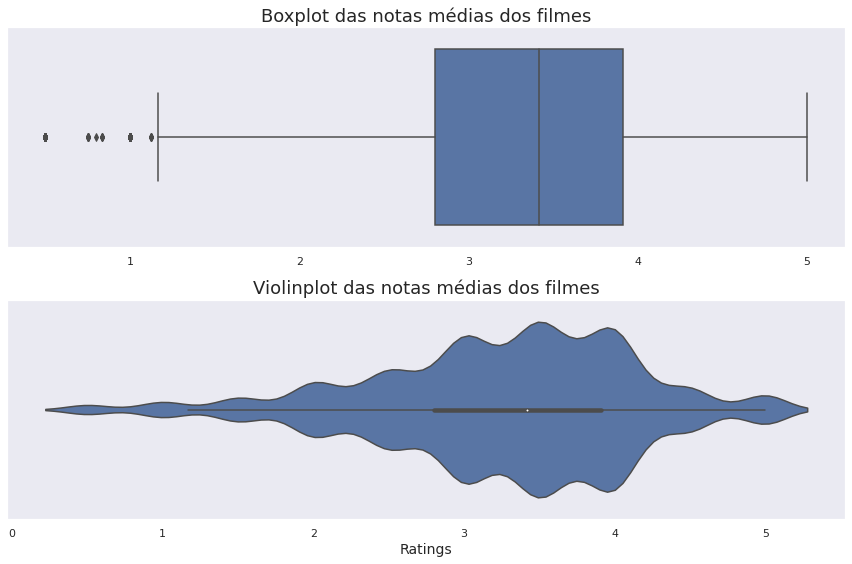

In [168]:
fig, axs = plt.subplots(2, figsize=(12,8))

sns.boxplot(x=mean_rating.rating, ax=axs[0])
axs[0].set(xlabel = '')
axs[0].set_title('Boxplot das notas médias dos filmes')

sns.violinplot(x=mean_rating.rating, ax=axs[1])
axs[1].set_title('Violinplot das notas médias dos filmes')
axs[1].set_xlabel('Ratings')

plt.tight_layout()
plt.show()

A nota média dos filmes se assemelha a uma curva assimétrica a esquerda, de modo que a maior parte das notas encontra-se entre 3 e 4. Notas médias abaixo de 2 a acima de 4,5 são menos comuns. Pelo Boxplot, notas abaixo de aproximadamente 1,2 são consideradas *outliers*

## 2.7 Como é a distribuição dos filmes em relação ao ano de lançamento?

In [232]:
rating_medio_por_ano.head(3)

,ano,rating,count
0,1902,3.5,5
1,1903,2.5,2
2,1908,4.0,1


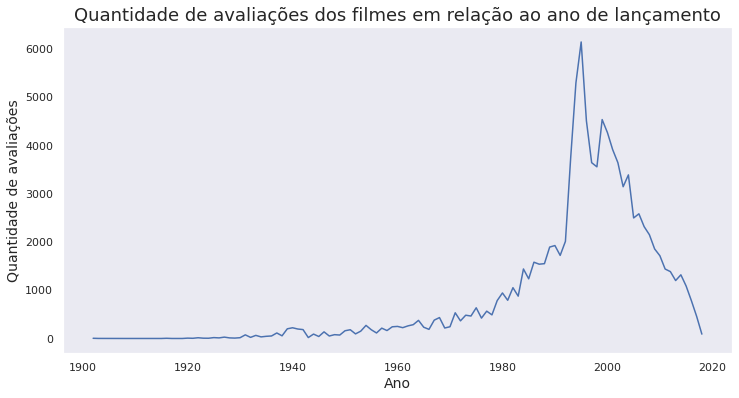

In [230]:
fig = plt.figure(figsize=(12,6))

#Gráfico de Linha
ax = sns.lineplot(x = 'ano', y = 'count', data = rating_medio_por_ano)
ax.set(ylabel = 'Quantidade de avaliações', xlabel = 'Ano')
ax.set_title('Quantidade de avaliações dos filmes em relação ao ano de lançamento')

plt.show()

As avaliações possuem uma semelhança comum uma distribuição assimétrica à esquerda, com o pico de notas referentes a filmes lançados entre os anos de 1990 e 2000.

Podemos comparar a distribuição das avaliações com o número de filmes lançados a cada ano.

In [228]:
# Construir uma tabela de frequência do número avaliações e filmes por ano de lançamento

# Colunas com o número de avaliações total e normaizada (avaliações no ano / total de avaliações)
freq_ano = rating_medio_por_ano.loc[:, ['ano', 'count']].rename(columns={'count': 'count ratings'}).set_index('ano')
total_ratings = freq_ano['count ratings'].sum()
freq_ano['Frequência de Avaliações'] = freq_ano['count ratings'] / total_ratings

# Colunas com o número de filmes total e normalizado (filmes no ano / total de filmes)
freq_ano = freq_ano.merge(ano_movies.groupby('ano')['movieId'].count().rename('count movies'), how='outer', left_index=True, right_index=True)
total_movies = freq_ano['count movies'].sum()
freq_ano['Frequência de Filmes'] = freq_ano['count movies'] / total_movies

freq_ano.head()

,count ratings,Frequência de Avaliações,count movies,Frequência de Filmes
ano,,,,
1902,5,0.00005,1,0.000103
1903,2,0.00002,1,0.000103
1908,1,0.00001,1,0.000103
1915,1,0.00001,1,0.000103
1916,5,0.00005,4,0.000411


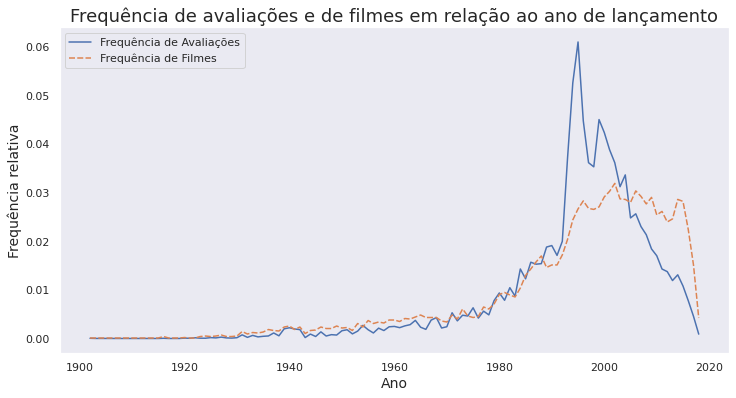

In [234]:
fig = plt.figure(figsize=(12,6))

ax = sns.lineplot(data=freq_ano[['Frequência de Avaliações', 'Frequência de Filmes']])
ax.set(ylabel = 'Frequência relativa', xlabel = 'Ano')
ax.set_title('Frequência de avaliações e de filmes em relação ao ano de lançamento')

plt.show()

Vamos destacas o período a partir de 1980, para melhor avaliar

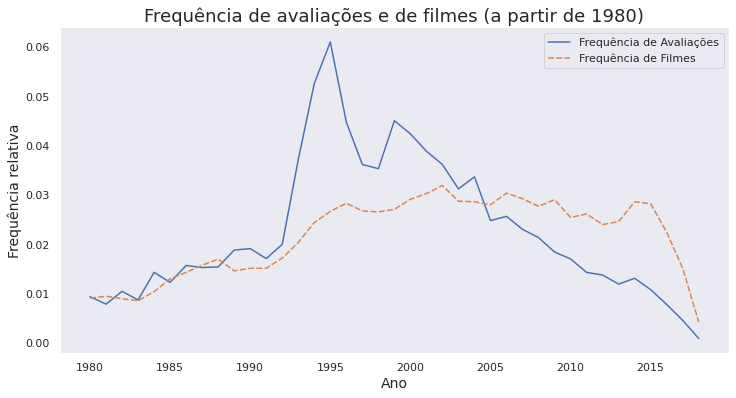

In [271]:
fig = plt.figure(figsize=(12,6))

ax = sns.lineplot(data=freq_ano.loc[1980:, ['Frequência de Avaliações', 'Frequência de Filmes']])
ax.set(ylabel = 'Frequência relativa', xlabel = 'Ano')
ax.set_title('Frequência de avaliações e de filmes (a partir de 1980)')

plt.show()

A proporção de avaliações de filmes lançados até o início da década de 90 é aproximadamente similar a proporção destes filmes em relação ao total de títulos. Os filmes lançados entre o ínicio da década de 1990 até por volta de 2005, receberam, proporcionalmente, mais avaliações do que qualquer outro período. A partir de então, os lançamentos começaram a receber menos avaliações, apesar de manterem uma frequência de novos lançamentos mais ou menos constante nas duas últimas décadas.

## 2.8 Existe uma correlação entre a nota média dos filmes e a quantidade de tags?

In [73]:
# Criando DF que lista a nota média dos filmes com a quantidade de tags atribuidas a ele
mean_rating_tag = mean_rating.copy()
mean_rating_tag['tag'] = tags_df.groupby('movieId').count().tag
mean_rating_tag.dropna(inplace = True)
mean_rating_tag.head()

,rating,tag
movieId,,
1,3.92,3.0
2,3.43,4.0
3,3.26,2.0
5,3.07,2.0
7,3.19,1.0


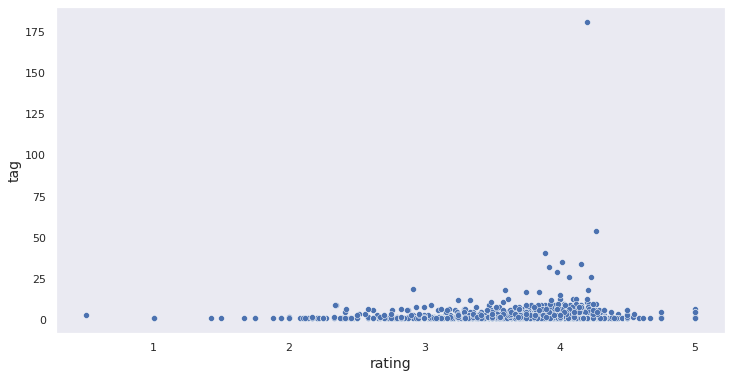

In [74]:
# Gráfico de Dispersão TAG x Rating
fig = plt.figure(figsize=(12,6))
sns.scatterplot(y = mean_rating_tag['tag'], x =mean_rating_tag['rating'])

plt.show()

In [75]:
mean_rating_tag.corr().round(3)

,rating,tag
rating,1.000,0.079
tag,0.079,1.000


O Coeficiente de correlação de Pearson é próximo de 0, ou seja, não existe uma correlação direta entre a nota média dos filmes e a quantidade de vezes que os usuários inseriram rótulos.

## 2.9 Filmes que se enquadram em mais generos possuem uma avaliação melhor?

In [76]:
# Montando DF da quantidade de generos por filme
quantidade_de_generos = generos.sum(axis = 1)
movie_qtd_generos= pd.concat([movies_df, quantidade_de_generos], axis = 1)
movie_qtd_generos.rename(columns = {0:'Quantidade de Generos'}, inplace = True)
movie_qtd_generos.drop('genres', axis = 1, inplace = True)
movie_qtd_generos.set_index('movieId', inplace = True)
movie_qtd_generos.head()

,title,Quantidade de Generos
movieId,,
1,Toy Story (1995),5
2,Jumanji (1995),3
3,Grumpier Old Men (1995),2
4,Waiting to Exhale (1995),3
5,Father of the Bride Part II (1995),1


In [77]:
# Criando DF do rating médio por movieId
rating_medio_por_filme = ratings_df[['movieId','rating']].groupby('movieId').mean().round(2)

# Concatenando DF
movie_qtd_generos_e_rating = pd.concat([movie_qtd_generos, rating_medio_por_filme], axis = 1)
movie_qtd_generos_e_rating.head()

,title,Quantidade de Generos,rating
movieId,,,
1,Toy Story (1995),5,3.92
2,Jumanji (1995),3,3.43
3,Grumpier Old Men (1995),2,3.26
4,Waiting to Exhale (1995),3,2.36
5,Father of the Bride Part II (1995),1,3.07


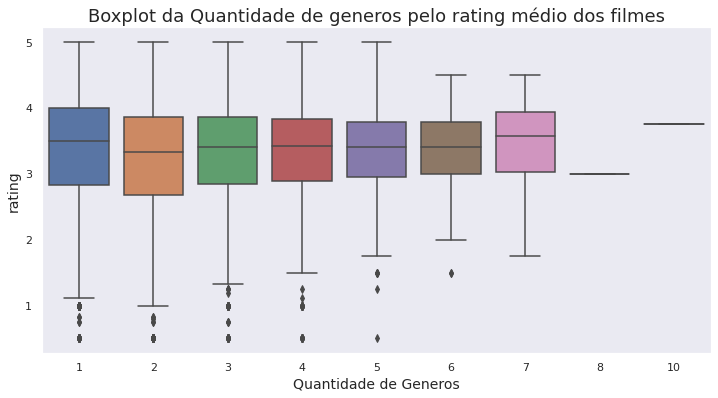

In [78]:
# Boxplot da Quantidade de generos pelo rating médio dos filmes
fig = plt.figure(figsize=(12,6))
ax = sns.boxplot(y = movie_qtd_generos_e_rating['rating'], x = movie_qtd_generos_e_rating['Quantidade de Generos'])
ax.set_title('Boxplot da Quantidade de generos pelo rating médio dos filmes')
plt.show()

In [79]:
movie_qtd_generos_e_rating.corr()

,Quantidade de Generos,rating
Quantidade de Generos,1.000000,0.000306
rating,0.000306,1.000000


Pelo valor do coeficiente de correlação e pela análise do Boxplot, a quantidade de generos do filme não afeta a nota dada pelo usuário

## 2.10 Montar modelo de Clusterização para separar os filmes em 5 grupos em relação aos gêneros

In [80]:
np.random.seed(1234)
# Separar os generos por colunas
generos = movies_df['genres'].str.get_dummies()

# Escalar os generos
from sklearn.preprocessing import StandardScaler
escalador = StandardScaler()
generos_escalados = escalador.fit_transform(generos)

# Clusterizar os filmes em 5 grupos
from sklearn.cluster import KMeans
modelo = KMeans(n_clusters = 5)
modelo.fit(generos_escalados)

# Montar um DF dos grupos com os centroids e em relação aos grupos
grupos = pd.DataFrame(modelo.cluster_centers_, columns = generos.columns).T
grupos.head()

,0,1,2,3,4
(no genres listed),-0.059195,-0.059195,0.041413,-0.059195,-0.059195
Action,0.336104,0.377689,-0.242748,0.768904,-0.104539
Adventure,-0.165170,0.038004,-0.176177,0.536754,0.911130
Animation,-0.240615,-0.204350,-0.251552,0.068511,2.186738
Children,-0.263983,-0.260059,-0.270526,-0.236942,2.719653


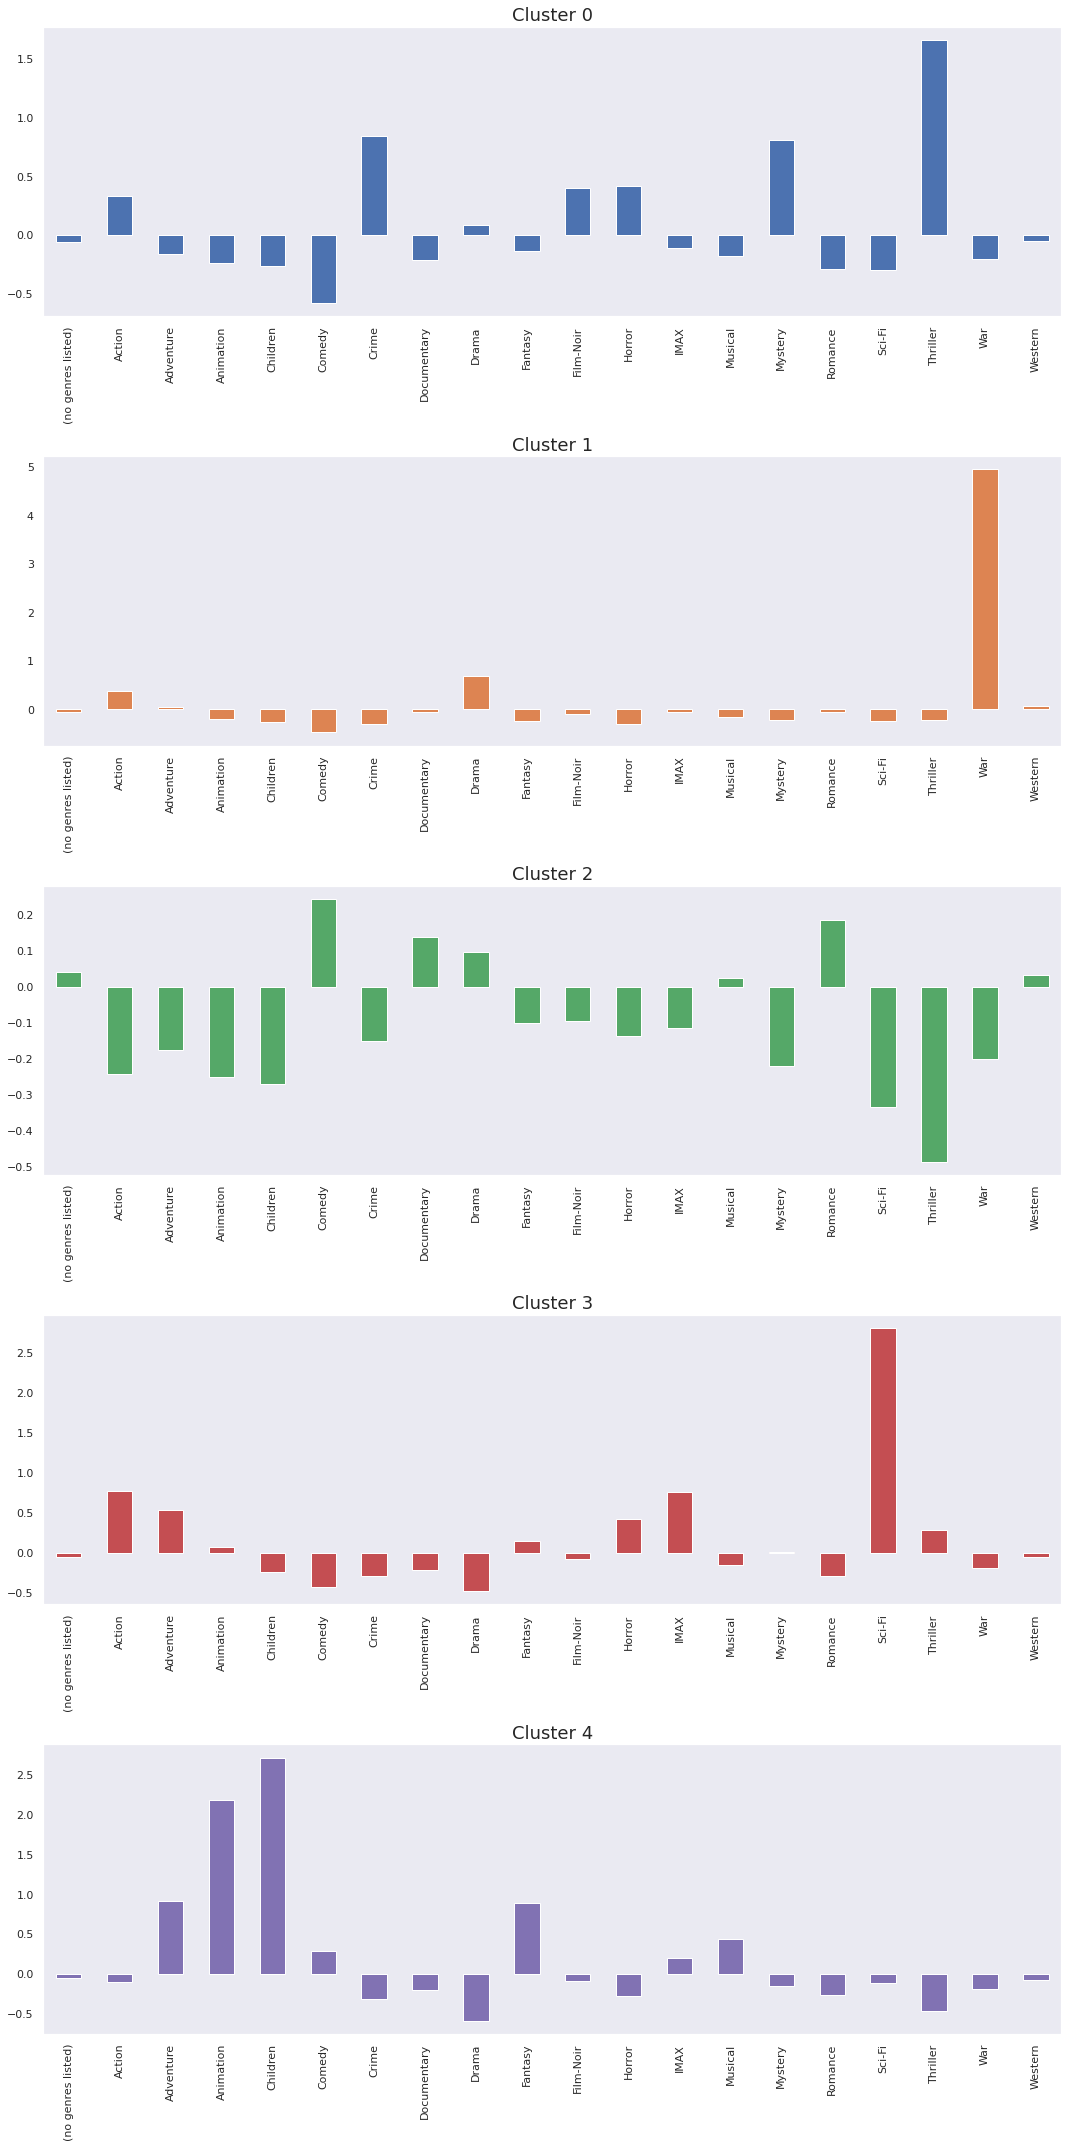

In [81]:
axs = grupos.plot.bar(subplots = True, figsize = (15,30), sharex = False)
for ax in axs:
    ax.set_title(f'Cluster {ax.get_title()}')
    ax.get_legend().remove()
plt.tight_layout()
plt.show()

In [82]:
cluster_filmes = modelo.predict(generos_escalados)
for i in range(0,5):
    print(f'Cluster {i}: {np.bincount(cluster_filmes)[i]} filmes ({round(np.bincount(cluster_filmes)[i] / len(cluster_filmes) * 100,2)}%)')

Cluster 0: 1819 filmes (18.68%)
Cluster 1: 379 filmes (3.89%)
Cluster 2: 5729 filmes (58.84%)
Cluster 3: 945 filmes (9.71%)
Cluster 4: 865 filmes (8.88%)


Separando os generos dos filmes pelo KMeans em 5 grupos, pode-se definir os grupos da seguinte foram



> Grupo 0: Filmes de *Crime*, *Mystery*  e *Thriller*

> Grupo 1: Filmes *War* com um pouco de *Drama*

> Grupo 2: Filmes de *Comedy*, *Romance* e *Drama*.  Com  baixa categorização de *Thriller*, *Sci-fi*, *Action*, *Adventure*, *Animation* e *Children*

> Grupo 3: Filme *Sci-fi*, *Action*, *Adventure* em formato *IMAX*

> Grupo 4: Filmes de *Children*, *Animation*, *Adventure* e *Fantasy*
